## Calculate OLR versus $T_s$ with radiative-convective atmospheres

### Import things
This assumes that SOCRATES is installed at `AGNI/socrates/`. Modify this as required.

In [1]:
# Set directory
ROOT_DIR = abspath(joinpath(pwd(),"../"))
ENV["RAD_DIR"] = joinpath(ROOT_DIR,"socrates")

"/home/n/nichollsh/AGNI/socrates"

In [2]:
# Import system packages
using Printf
using Plots

# Import AGNI
using AGNI
import AGNI.atmosphere as atmosphere
import AGNI.solver as nl
import AGNI.dump as dump
import AGNI.plotting as plotting

# Use Normal-level logging from AGNI module
AGNI.setup_logging("",1)

### Define atmosphere parameters

In [3]:
# Configuration options
instellation    = 1360.0  # Solar constant [W m-2]
gravity         = 9.81
radius          = 6.37e6
nlev_centre     = 35
p_surf          = 270.0     # bar
t_surf          = 3000.0
p_top           = 1e-5      # bar 
mole_fractions  = Dict([("H2O", 1.0), ("N2",1.0e-9)])   # needs a small amount of background gas with zero opacity
condensates     = ["H2O"]

spectral_file = joinpath(ROOT_DIR,"res/spectral_files/Frostflow/48/Frostflow.sf")
star_file     = joinpath(ROOT_DIR,"res/stellar_spectra/sun.txt");


In [4]:
# Create output directory
output_dir = joinpath(ROOT_DIR,"out")
rm(output_dir,force=true,recursive=true)
mkdir(output_dir);

### Initialise the atmosphere

In [5]:
# Setup atmosphere
atmos = atmosphere.Atmos_t()
atmosphere.setup!(atmos, ROOT_DIR, output_dir, 
                        spectral_file,
                        instellation, 0.375, 0.0, 48.19,
                        t_surf,  
                        gravity, radius,
                        nlev_centre, p_surf, p_top,
                        mole_fractions, "",
                        condensates=condensates,
                        flag_gcontinuum=true,
                        thermo_functions=true,
                        flag_rayleigh=true
                        )
atmosphere.allocate!(atmos, star_file)

[ INFO  ] Composition set by dict 
[ INFO  ] Inserting stellar spectrum and Rayleigh coefficients 
[ INFO  ] Allocated atmosphere with composition: 
[ INFO  ]       1 H2O     1.00e+00 (CON) 
[ INFO  ]       2 N2      1.00e-09 (NO_OPACITY) 


true

### Run the model for a high-temperature case
This provides an initial guess from which later simulations will be initialised

In [6]:
atmos.tmp_surf = 3050.0
atmos.tmpl[:] .= 3050
atmos.tmp[:] .= 3050;

In [7]:
solver_success = nl.solve_energy!(atmos, 
                                    sol_type=1,         # Conserve energy, but with fixed surface temperature
                                    sens_heat=true,    # Do not include sensible heat transport
                                    latent=true,        # Include condensation
                                    method=1,           # Use the Newton-Raphson method
                                    dx_max=400.0,       # Allow large step sizes because of the poor initial guess
                                    linesearch=true ,   # Enable Linesearch
                                    save_frames=false, modplot=1, # disable plotting 
                                    conv_atol=0.1
                                    )
println("Solver success? $solver_success")

[ INFO  ]     sol_type = 1 
[ INFO  ]     tmp_surf = 3050.00 K 
[ INFO  ]     step  resid_med    cost     flux_OLR   xvals_med  xvals_max  |dx|_max   flags 
[ INFO  ]        1  -2.84e+04  1.077e+06  3.200e+06  2.870e+03  3.050e+03  3.994e+02  C2-Nr-Ls 
[ INFO  ]        2  -1.81e+04  6.206e+05  1.872e+06  2.645e+03  3.050e+03  3.994e+02  C2-Nr-Ls 
[ INFO  ]        3  -9.30e+03  3.238e+05  9.905e+05  2.403e+03  3.050e+03  3.994e+02  C2-Nr-Ls 
[ INFO  ]        4  -4.94e+03  1.565e+05  4.894e+05  2.158e+03  3.050e+03  3.994e+02  C2-Nr-Ls 
[ INFO  ]        5  -2.52e+03  7.837e+04  2.443e+05  1.913e+03  3.050e+03  3.994e+02  C2-Nr-Ls 
[ INFO  ]        6  -1.39e+03  3.917e+04  1.219e+05  1.650e+03  3.050e+03  3.994e+02  C2-Nr-Ls 
[ INFO  ]        7  -8.43e+02  2.687e+04  8.339e+04  1.437e+03  3.050e+03  2.710e+02  C2-Nr-Ls 
[ INFO  ]        8  -1.35e+03  2.336e+04  7.287e+04  1.341e+03  3.050e+03  9.535e+01  C2-Nr-Ls 
[ INFO  ]        9  -1.19e+03  2.093e+04  6.561e+04  1.269e+03  3.050e+03  

In [8]:
out = joinpath(output_dir, "base.ncdf")
dump.write_ncdf(atmos, out);

Plot this profile, to check that it looks reasonable...

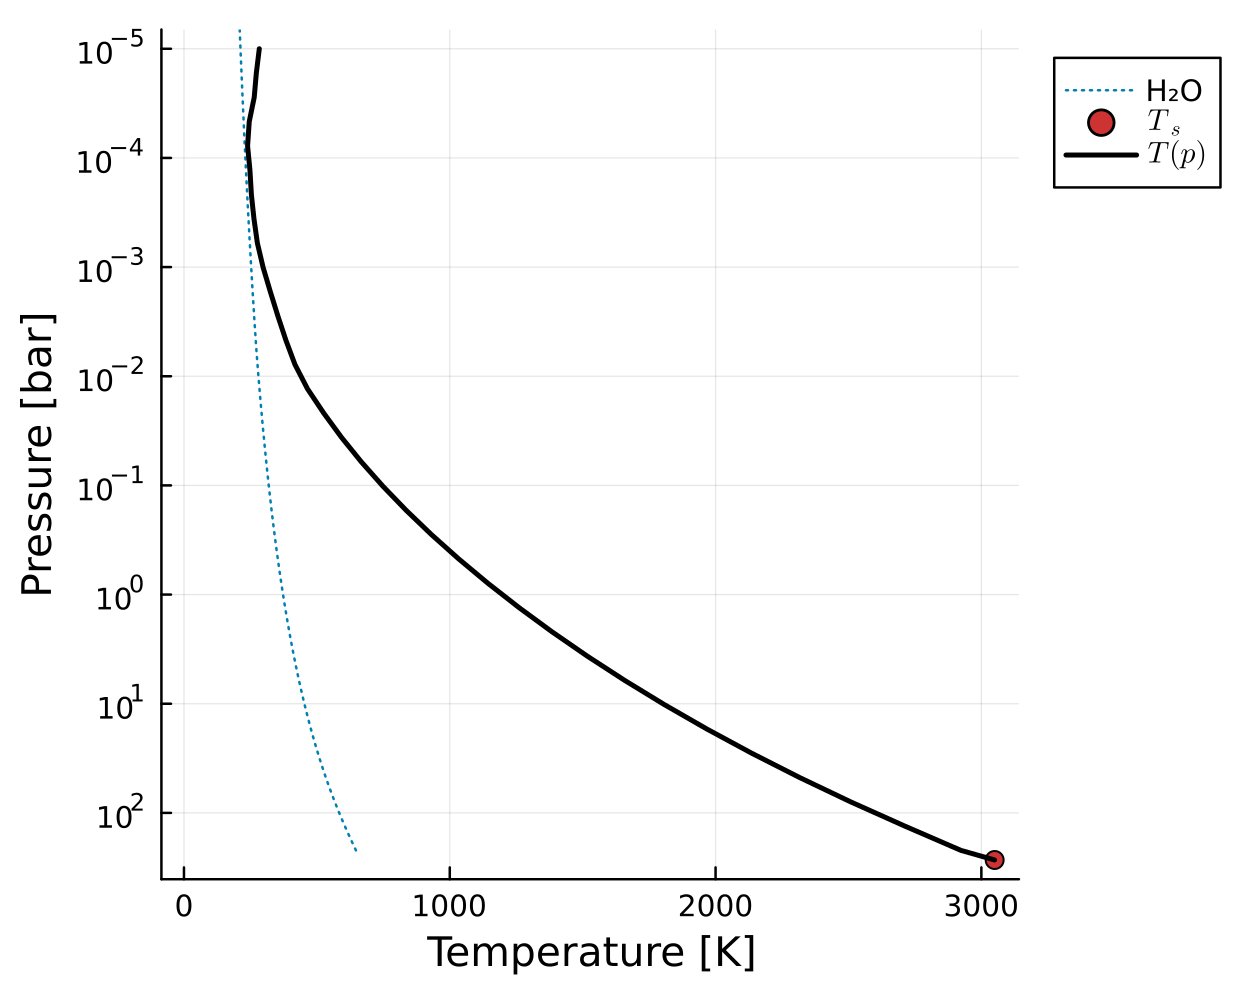

In [9]:
plotting.plot_pt(atmos, "")

This shows convection from the surface and condensation in the upper atmosphere. This is because there's large upward energy flux as the planet attempts to cool down under the modest instellation.     

### Run the model for a range of surface temperatures
Note that the solver will not print each step to the notebook, to avoid clutter here.

In [10]:
num_loops = 10
tmp_arr = range(start=3000.0, stop=1000.0, length=num_loops)
atm_arr = atmosphere.Atmos_t[]

@printf("Running model for %d samples... \n", num_loops)

for (i,tmp) in enumerate(tmp_arr)
    # Set new surface temperature 
    @printf("Running model for tmp_surf = %.1f K \n",tmp)
    atmos.tmp_surf = tmp 

    # Help solver by changing initial guess
    clamp!(atmos.tmpl, 0.0, tmp)
    clamp!(atmos.tmp, 0.0, tmp)

    # Run model
    solver_success = nl.solve_energy!(atmos, 
                                    sol_type=1,         
                                    sens_heat=true,   
                                    latent=true,        
                                    method=1,           
                                    dx_max=500.0,        # Smaller steps
                                    linesearch=true ,   
                                    save_frames=false, modplot=1,
                                    modprint=0,
                                    conv_atol=0.1  
                                    )

    # Store result
    push!(atm_arr, deepcopy(atmos))

    @printf("--------------------------------- \n")
end 
println("Done!")

Running model for 10 samples... 
Running model for tmp_surf = 3000.0 K 
[ INFO  ]     sol_type = 1 
[ INFO  ]     tmp_surf = 3000.00 K 
[ INFO  ]     success in 4 steps 
[ INFO  ]     outgoing LW flux   = +3.50e+03 W m-2      
[ INFO  ]     total flux at TOA  = +3.20e+03 W m-2      
[ INFO  ]     total flux at BOA  = +3.20e+03 W m-2      
[ INFO  ]     column max loss    = +1.42e+00 W m-2  (+4.43e-02 %)  
[ INFO  ]     final cost value   = +1.40e+00 W m-2      
[ INFO  ]     surf temperature   = 3000.000  K         
--------------------------------- 
Running model for tmp_surf = 2777.8 K 
[ INFO  ]     sol_type = 1 
[ INFO  ]     tmp_surf = 2777.78 K 


### Make plot of temperature profiles

In [ ]:
fontsize=12
linewidth=1.5;

In [ ]:
arr_P = atmos.pl .* 1.0e-5 # Convert Pa to bar
ylims  = (arr_P[1], arr_P[end])
yticks = 10.0 .^ round.(Int,range( log10(ylims[1]), stop=log10(ylims[2]), step=1))

plt = plot(framestyle=:box, size=(700,500), dpi=300, 
                leg=:topright, legcolumn=-1,
                tickfontsize=fontsize, guidefontsize=fontsize, 
                legendfontsize=fontsize, leg_title="Ts [K]")

p = Plots.palette(:viridis, num_loops)
for (i,this_atm) in enumerate(atm_arr)
    plot!(plt, this_atm.tmpl, this_atm.pl* 1.0e-5, lc=p[i], linewidth=linewidth, label=@sprintf("%d",this_atm.tmp_surf))
end 

xlabel!(plt, "Temperature [K]")
xaxis!(plt, minorgrid=true)
ylabel!(plt, "Pressure [bar]")
yflip!(plt)
yaxis!(plt, yscale=:log10, ylims=ylims, yticks=yticks)
display(plt)
savefig(plt,joinpath(output_dir,"profiles.pdf"))

### Make plot of OLR vs $T_s$

In [ ]:
# Collect data
olr_arr = Float64[]
tot_arr = Float64[]
for this_atm in atm_arr
    push!(olr_arr, this_atm.flux_u_lw[1])
    push!(tot_arr, this_atm.flux_tot[1])
end 


In [ ]:
# Make plot
plt = plot(framestyle=:box, size=(700,450),
            tickfontsize=fontsize, guidefontsize=fontsize, legendfontsize=fontsize,
            xlims=(tmp_arr[end]-50, tmp_arr[1]+50),
            ylims=(-10.0, maximum(olr_arr)+50))

hline!(plt, [281.0], label="S-N limit", color="black", linestyle=:dash)

# Plot curves
marker = (:circle,4)
plot!(plt, tmp_arr, olr_arr, linewidth=linewidth, marker=marker, label="OLR", color="red")
plot!(plt, tmp_arr, tot_arr, linewidth=linewidth, marker=marker, label="Total", color="blue")

# Decorate
xlabel!(plt, "Surface temperature [K]")
ylabel!(plt, "Energy flux [W m⁻²]")
xaxis!(plt, minorgrid=true)
display(plt)
savefig(plt,joinpath(output_dir,"curve.pdf"))
println("Done!")